### Imports

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import itertools
import matplotlib.pyplot as plt
from terminaltables import AsciiTable

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

# Set color map
cmap = plt.get_cmap('viridis')

### Load datasets

In [2]:
# Load feature set and target values
dataset = pd.read_pickle('data/dataset')
# Load corresponding articles
articles = pd.read_pickle('data/articles')

### Prepare data

In [3]:
# Extract list of feature names ('blog' is target column)
feature_names = [col for col in dataset.columns if col != 'blog']

# Turn features and target column into numpy arrays
X = normalize(dataset[feature_names].values)
y = dataset['blog'].values.flatten()

# Total number of samples
n = len(X)

# Test set: 20% of total number of samples (randomly selected)
test_idx = np.random.choice(range(n), size=int(0.2*n), replace=False)
train_idx = np.isin(np.arange(n), test_idx, invert=True)

# Split the training and test sets
X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]

### Classify

In [4]:
# Define classifier
clf = RandomForestClassifier(n_estimators=100)

# Fit - Train
clf.fit(X_train, y_train)

# Make a prediction on test set
y_pred = clf.predict(X_test)

# Measure the performance of the model
print ("Test set accuracy: %.2f%%\n" %  float(100*accuracy_score(y_test, y_pred)))

print (classification_report(y_test, y_pred, target_names=['News', 'Blog']))


Test set accuracy: 75.85%

             precision    recall  f1-score   support

       News       0.77      0.75      0.76      2028
       Blog       0.75      0.77      0.76      1972

avg / total       0.76      0.76      0.76      4000



### Save prediction results

In [14]:
results = pd.DataFrame()
results['id'] = articles.iloc[test_idx]['id']

# Gold column consists of true media type
results.loc[y_test == 0, 'gold'] = 'News'
results.loc[y_test == 1, 'gold'] = 'Blog'

# Prediction column consists of models predictions
results.loc[y_pred == 0, 'prediction'] = 'News'
results.loc[y_pred == 1, 'prediction'] = 'Blog'

# Save to a csv-file
results.to_csv('data/results.csv', index=False)


### Plot confusion matrix

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


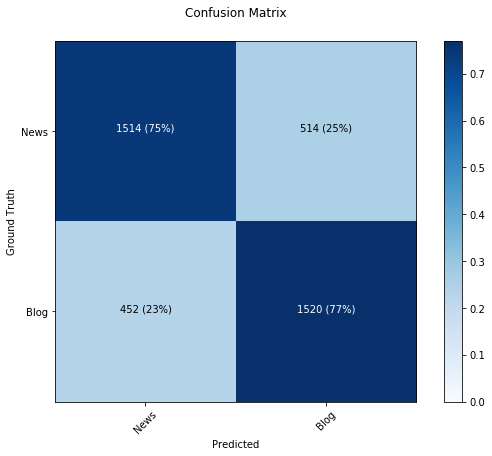

In [6]:

# Get confusion matrix by using sklearn method
cm = confusion_matrix(y_test, y_pred)

# Scale values so that columns sum to 1
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Draw matrix
fig = plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix')
ax = fig.add_subplot(111)
cax = ax.matshow(cm_norm, interpolation='none', cmap=plt.cm.Blues, vmin=0, vmax=np.max(cm_norm))
ax.xaxis.tick_bottom()
# Add color bar which shows color - scale map
fig.colorbar(cax)

# Show number of samples and percentage of samples in each bucket
thresh = cm_norm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, '%d (%.f%%)' % (cm[i,j], float(100*cm_norm[i,j])),
             horizontalalignment='center',
             color='white' if cm_norm[i, j] > thresh else 'black')

plt.tight_layout()

# Show labels
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.xticks(np.arange(2), ('News', 'Blog'), rotation=45)
plt.yticks(np.arange(2), ('News', 'Blog'))

plt.show()
plt.close()

### Extract feature importance from Random Forest

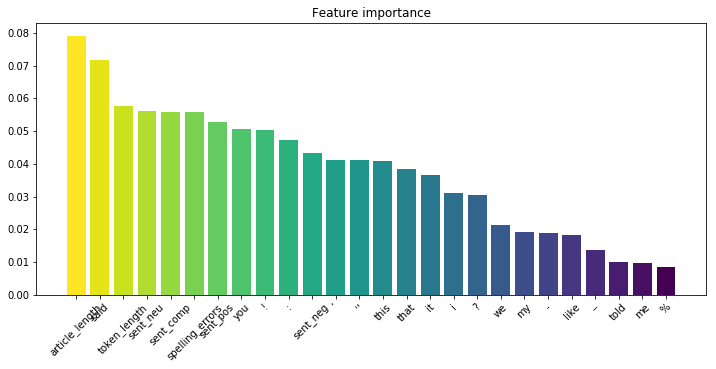

In [7]:

# Get feature importances from the RandomForestClassifier
importances = clf.feature_importances_

# Sort indices by the corresponding feature's importance
idx = np.argsort(importances)[::-1]

# Sort features and importances from highest to lowest importance
sorted_feature_names = [feature_names[i] for i in idx]
sorted_importances = [importances[i] for i in idx]

# Get color spectrum
colors = [cmap(i) for i in np.linspace(0, 1, len(idx))][::-1]

# Plot features from highest to lowest feature importance
plt.figure(figsize=(12, 5))
plt.title("Feature importance")
plt.bar(range(len(idx)), sorted_importances, color=colors)
plt.xticks(range(len(idx)), sorted_feature_names, rotation=45)
plt.show()
plt.close()